## PŘÍPRAVA DAT (PREPROCESSING)

In [2]:
import pandas as pd
from unidecode import unidecode
from sklearn.preprocessing import StandardScaler
import unicodedata
import re

# Funkce pro odstranění diakritiky
def remove_diacritics(text):
    return unidecode(text)

# Funkce pro úpravu názvů sloupců
def fix_column_names(df):
    df.columns = [unidecode(col).replace(' ', '_').lower() for col in df.columns]
    return df

# Načtení datového souboru
file_path = 'NAPO_VSE_oprava.xlsx'
df = pd.read_excel(file_path, sheet_name='Labels')

# Úprava názvů sloupců
df = fix_column_names(df)

# Převedení numerických hodnot na int a float
df = df.convert_dtypes()

# Funkce pro normalizaci textu v buňkách
def normalize_text(text):
    if pd.isna(text):
        return text
    # Odstranění diakritiky, převod na malá písmena, nahrazení whitespace za "_"
    text = ''.join(c for c in unicodedata.normalize('NFD', str(text)) if unicodedata.category(c) != 'Mn')
    text = text.replace(' ', '_').lower()
    return text

# Aplikace normalizace textu na všechny buňky v DataFrame
df = df.applymap(normalize_text)

# Zobrazení prvních několika řádků pro ověření
print(df.head())

# Úložení předzpracovaných dat do nového excelu
df.to_excel('NAPO_VSE_preprocessed.xlsx', index=False)

print("Předzpracovaná data byla uložena do 'NAPO_VSE_preprocessed.xlsx'")

  id_respondenta pohlavi vek vekova_kategorie  \
0    025y2-0ce-1    zena  39        35-44_let   
1    032y2-0ce-1    zena  42        35-44_let   
2    04gy2-0ce-1     muz  60        55-64_let   
3    05l03-0ce-1    zena  56        55-64_let   
4    06vx2-0ce-1     muz  73    65_a_vice_let   

                   nejvyssi_dokoncene_vzdelani  vzdelani_\n(rekod)  \
0      vyssi_odborne,_vysokoskolske_bakalarske              vs/vos   
1  stredoskolske_s_maturitou_(vcetne_nastavby)      ss_s_maturitou   
2            vysokoskolske_magisterske_a_vyssi              vs/vos   
3                       vyucen(a)_bez_maturity  zs/ss_bez_maturity   
4  stredoskolske_s_maturitou_(vcetne_nastavby)      ss_s_maturitou   

               kraj jakou_znamkou_byste_ohodnotil(a)_ceske_zdravotnictvi?  \
0  stredocesky_kraj                                                  2      
1  stredocesky_kraj                                                  3      
2      ustecky_kraj                                  

### Kategorizace otázky Jaký je čistý měsíční příjem Vaší domácnosti?

In [3]:
# Funkce pro kategorizaci příjmu
def categorize_income(income):
    if income in ['do_19_999_kc']:
        return 'nizky_prijem'
    elif income in ['20_000_kc_-_49_999_kc', '50_000_kc_-_74_999_kc']:
        return 'stredni_prijem'
    elif income in ['75_000_kc_-_99_999_kc', '100_000_kc_-_149_000_kc', '150_000_kc_a_vice']:
        return 'vysoky_prijem'
    elif income in ['odmitam_odpovedet', 'nevim']:
        return 'neurceno'
    else:
        return 'n'

# Aplikace funkce na sloupec a vytvoření nové kategorie
df['prijem_kategorie'] = df['jaky_je_cisty_mesicni_prijem_vasi_domacnosti?'].apply(categorize_income)

# Zobrazení prvních několika řádků pro ověření
print(df[['jaky_je_cisty_mesicni_prijem_vasi_domacnosti?', 'prijem_kategorie']].head())


  jaky_je_cisty_mesicni_prijem_vasi_domacnosti? prijem_kategorie
0                         50_000_kc_-_74_999_kc   stredni_prijem
1                         20_000_kc_-_49_999_kc   stredni_prijem
2                             odmitam_odpovedet         neurceno
3                                  do_19_999_kc     nizky_prijem
4                         50_000_kc_-_74_999_kc   stredni_prijem


### Oprava odpovědí k otázce Jakou známkou byste ohodnotil/a české zdravotnictví?

In [4]:
# Funkce pro převod textových hodnot hodnocení na integer podle první číslice
def convert_rating_to_int(value):
    if pd.isna(value):
        return value
    match = re.match(r'(\d)_', value)
    if match:
        return int(match.group(1))
    else:
        try:
            return int(value)
        except ValueError:
            return pd.NA

# Seznam sloupců pro konverzi
columns_to_convert = [
    'jakou_znamkou_byste_ohodnotil(a)_ceske_zdravotnictvi?',
    'hodnoceni_zdravotni_pojistovny',
    'hodnoceni_zdravotnicka_zarizeni_/_lekari',
    'hodnoceni_ministerstvo_zdravotnictvi',
    'hodnoceni_nemocnice', 
    'hodnoceni_prakticky_lekar',
    'hodnoceni_ambulantni_specialiste'
]

# Aplikace konverze na vybrané sloupce
for col in columns_to_convert:
    df[col] = df[col].apply(convert_rating_to_int)

# Převedení numerických hodnot na int a float
df = df.convert_dtypes()

# Uložení upravených dat do nového Excel souboru
df.to_excel('NAPO_VSE_preprocessed.xlsx', index=False)

print("Data s opravou hodnocení byla uložena do 'NAPO_VSE_preprocessed.xlsx'")

Data s opravou hodnocení byla uložena do 'NAPO_VSE_preprocessed.xlsx'


### Textová analýza (NLP) otázky Co na českém zdravotnictví oceňujete? 

[nltk_data] Downloading package punkt to C:\Users\Hoang
[nltk_data]     Anh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


           category  frequency
1        dostupnost         69
3               nic         68
2             nevim         59
13        odbornost         34
19          kvalita         26
9            zdarma         14
11          vsechno         12
14   profesionalita          7
50           ochotu          6
22        vyspelost          6
35       trpelivost          5
61           ochota          5
49      pristupnost          4
45        peclivost          4
30         rychlost          4
70             cenu          4
58        bezplatne          3
34           lekare          3
48  kvalifikovanost          3
40           pokrok          3


<Figure size 1200x600 with 0 Axes>

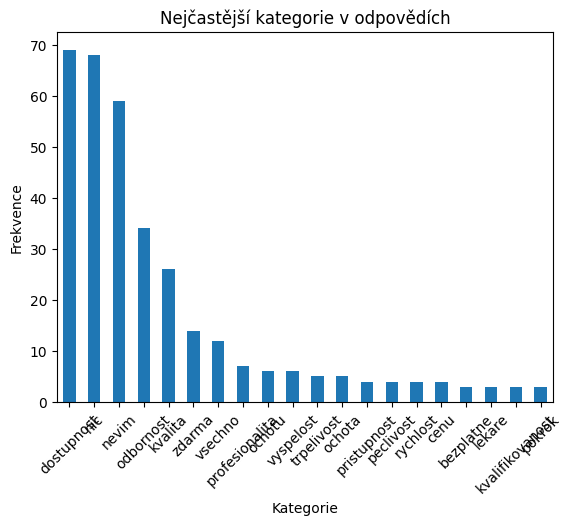

Výsledky byly uloženy do souboru 'NAPO_VSE_nlp.xlsx'.


In [11]:
import pandas as pd
import unicodedata
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Stažení NLTK dat pro tokenizaci (je-li potřeba)
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# Načtení českých stop slov ze souboru
stop_words_file_path = 'stop_words_czech.txt'
with open(stop_words_file_path, 'r', encoding='utf-8') as file:
    czech_stop_words = [line.strip() for line in file.readlines()]

# Rozšířený slovník synonym
synonyms_dict = {
    'kvalita': 'kvalita',
    'kvalitu': 'kvalita',
    'kvalitni_pece': 'kvalita',
    'vysoka_odbornost': 'odbornost',
    'odbornost': 'odbornost',
    'odbornici': 'odbornost',
    'odbornost_lekaru': 'odbornost',
    'profesionalitu': 'odbornost',
    'dostupnost': 'dostupnost',
    'bezplatnost': 'zdarma',
    'bezplatnou_peci': 'zdarma',
    'ze_je_zdarma': 'zdarma',
    'asi_nic': 'nic',
    'nic_me_nenapada': 'nic',
    'vse': 'vsechno',
    'vubec_nic': 'nic',
    'relativni_dostupnost': 'dostupnost',
    'profesionalni': 'profesionalita',
    'nektere_lekare': 'lekare',
    'lekare': 'lekare',
    'bez_poplatku': 'zdarma',
    'rychlost': 'rychlost',
    'pohodli': 'pohodli',
    'vstricnost': 'vstricnost',
    'ochota': 'ochota',
    'pristup': 'pristup',
    'spolehlivost': 'spolehlivost'
}

# Funkce pro odstranění diakritiky
def remove_diacritics(text):
    return ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

# Funkce pro zpracování textu
def process_text(text, synonyms_dict, stop_words):
    text = remove_diacritics(text.lower())
    words = [word for word in word_tokenize(text) if word.isalnum() and word not in stop_words]
    found_categories = [synonyms_dict.get(word, word) for word in words]
    return ' '.join(sorted(set(found_categories)))

# Načtení datového souboru
df = pd.read_excel('NAPO_VSE_preprocessed.xlsx', sheet_name='Sheet1')

# Zpracování textu a vytvoření nového sloupce
df['co_na_ceskem_zdravotnictvi_ocenujete_klic_slova'] = df['co_na_ceskem_zdravotnictvi_ocenujete?'].astype(str).apply(
    lambda x: process_text(x, synonyms_dict, czech_stop_words)
)

# Počítání frekvence kategorií
all_categories = [cat for sublist in df['co_na_ceskem_zdravotnictvi_ocenujete_klic_slova'].str.split() for cat in sublist if cat]
category_freq = Counter(all_categories)

# Vytvoření DataFrame z frekvencí kategorií
category_freq_df = pd.DataFrame(category_freq.items(), columns=['category', 'frequency']).sort_values(by='frequency', ascending=False)

# Zobrazení nejčastějších kategorií
print(category_freq_df.head(20))

# Vizualizace - sloupcový graf
plt.figure(figsize=(12, 6))
category_freq_df.head(20).plot(kind='bar', x='category', y='frequency', legend=False)
plt.title('Nejčastější kategorie v odpovědích')
plt.xlabel('Kategorie')
plt.ylabel('Frekvence')
plt.xticks(rotation=45)
plt.show()

# Uložení výsledků do Excelu s novým sloupcem
output_file_path = 'NAPO_VSE_nlp.xlsx'
with pd.ExcelWriter(output_file_path, engine='openpyxl', mode='w') as writer:
    df.to_excel(writer, sheet_name='Sheet1', index=False)

print(f"Výsledky byly uloženy do souboru '{output_file_path}'.")
